In [1]:
from brian2 import *
#import numpy as np
# from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline

Excitatory Neurons:
$$ \tau_m^+ \frac{\phi^P(\vec r, t+\Delta t)  - \phi^p(\vec r, t)}{\Delta t} + \phi^P(\vec r, t) = \Sigma_{P', \vec r'} w^+(\vec r - \vec r' - \xi \vec e^P)s^{P'}(\vec r', t - \tau_s^{++}) + \Sigma_{\vec r'}w^-(\vec r - \vec r')s^-(\vec r', t - \tau_s^-) + a^+(\vec r)[1 + \alpha E^P \bullet V(t)] + \zeta^P(\vec r, t)  $$

Inhibitory Neurons:
$$ \tau_m^+ \frac{\phi^-(\vec r, t+\Delta t)  - \phi^-(\vec r, t)}{\Delta t} + \phi^-(\vec r, t) = \Sigma_{P', \vec r'} w^+(\vec r - \vec r' - \xi \vec e^P)s^{P'}(\vec r', t - \tau_s^{++}) + a^-(t) + \zeta^-(\vec r, t)  $$

Synaptic connectivity from excitatory to all neurons
$$ w^+(\vec r) = \begin{cases}
                w_{mag} ^+{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < rw+\\
                0          & \text{; } r\geq rw+
         \end{cases}
                $$
Synaptic connectivity from inhibitory to excitatory neurons
$$ w^-(\vec r) = \begin{cases}
                -w_{mag} ^-{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < 2rw-\\
                0          & \text{; } r\geq 2rw-
         \end{cases}
                $$

$$ a^+(\vec r) = \begin{cases}
                -a_{min}^+ + (a^+_{max} - a^+_{min})^{\frac{1 + cos(\pi \rho /\rho_{a^+})}{2}}& \text{; } \rho < \rho a+\\
                a_{min}^+          & \text{; } \rho \geq \rho a+.
         \end{cases}
                $$

$$ a^-(t) = a_{mag}^- - a_{th}^-cos(t\pi ft + \psi_0)  $$

$$ \rho = \frac{\sqrt{(x - \frac{n+1/2}{2}^2 + (y - \frac{n+1}{2}^2)}}{n/2} $$

In [2]:
# start_scope() # creat a new scope


# # Parameters
# n = 40
# N = 232 * 232 # Neurons per population
# N = n * n

# tau_m_plus = 40*ms # Exc. membrane time constant
# tau_m_minus = 20*ms # Inh. membrane time constant
# tau_s_plus_plus = 5*ms # Exc.-to-exc. synaptic delay
# tau_s_minus_plus = 2*ms # Exc.-to-inh. synaptic delay
# tau_s_minus = 2*ms # Inh. synaptic delay
# a_max_plus = 2 # Exc. drive maximum
# a_min_plus = 0.8 # Exc. drive minimum
# rho_a_plus = 1.2 # Exc. drive scaled speed
# a_mag_minus = 0.72 # Inh. drive magnitude
# a_th_minus = 0.2 # Inh. drive theta amplitude
# f = 8*hertz # Inh. drive theta frequency
# w_mag_plus = 0.2 # Exc. synaptic strength
# r_w_plus = 6 # Exc. synaptic spread
# w_mag_minus = 2.8 # Inh. synaptic strength
# r_w_minus = 12 # Inh. synaptic distance
# xi = 3 # Exc. synaptic shift
# alpha = 0.25*second/metre # Exc. velocity gain
# var_zeta_P = 0.002**2 # Exc. noise magnitude
# var_zeta_I = 0.002**2 # Inh. noise magnitude


# duration = 1000*ms


#### Scaled Parameters

In [3]:
start_scope() # creat a new scope


# Parameters
n = 40
N = 232 * 232 # Neurons per population
N = n * n

tau_m_plus = 40*ms # Exc. membrane time constant
tau_m_minus = 20*ms # Inh. membrane time constant
tau_s_plus_plus = 5*ms # Exc.-to-exc. synaptic delay
tau_s_minus_plus = 2*ms # Exc.-to-inh. synaptic delay
tau_s_minus = 2*ms # Inh. synaptic delay
a_max_plus = 2 # Exc. drive maximum
a_min_plus = 0.8 # Exc. drive minimum
rho_a_plus = 1.2 # Exc. drive scaled speed
a_mag_minus = 0.72 # Inh. drive magnitude
a_th_minus = 0.2 # Inh. drive theta amplitude
f = 8*hertz # Inh. drive theta frequency
w_mag_plus = 0.2 # Exc. synaptic strength
r_w_plus = (6/232) * n # Exc. synaptic spread
w_mag_minus = 2.8 # Inh. synaptic strength
r_w_minus = (12/232) * n # Inh. synaptic distance
xi = (3/232) * n # Exc. synaptic shift
alpha = 0.25*second/metre # Exc. velocity gain
var_zeta_P = 0.002**2 # Exc. noise magnitude
var_zeta_I = 0.002**2 # Inh. noise magnitude


duration = 1000*ms


In [4]:
defaultclock.dt = 0.1*ms

### Velocity Inputs (Based on Rat Trajectory):
Two options:
1. Simulate the inputs (as done by Mittal & Narayanan, 2021)
2. Differentiate rat trajectories (as done by Burak & Fiete, 2009 and used in Kang & DeWeese 2019)


In [5]:
@implementation('numpy', discard_units=True)
@check_units(dir_x = metre, dir_y = metre, V_x = metre/second, V_y = metre/second, result= metre/second)
def dot_product(dir_x, dir_y, V_x, V_y):
    dir = [dir_x, dir_y]
    V = [V_x, V_y]
    product = dot(dir, V)
    print(product)
    return product * metre / second


In [6]:
dot_product(3 * metre, 2*metre, 1*metre/second, 5*metre/second)

13.0


13. * metre / second

In [7]:
eqns_exc_n = '''

x = i % sqrt(N) * metre : metre 
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = 0 * metre : metre
dir_y = 1 * metre: metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1

'''

eqns_exc_s = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = 0 * metre : metre
dir_y = -1 * metre : metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)
 
a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1
'''

eqns_exc_e = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = 1 * metre : metre
dir_y = 0 * metre : metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1
'''

eqns_exc_w = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

# Specify preferred direction
dir_x = -1 * metre : metre
dir_y = 0 * metre : metre

# Distance from centre
rho = rho_value(x / metre, y / metre, N) : metre (constant over dt)

a_plus = a_plus_value(rho / metre) : 1 (constant over dt)

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus*(1 + alpha*dot_product(dir_x, dir_y, V_x(t), V_y(t)))/tau_m_plus : 1
'''


""" 
eqns_exc = '''

dv/dt = -v/tau_m_plus  + var_zeta_P*xi*tau_m_plus**-0.5 + a_plus/tau_m_plus : 1

'''  """

eqns_inh = '''

x = i % sqrt(N) * metre : metre
y = i // sqrt(N) * metre : metre

dv/dt = -(v - a_minus)/tau_m_minus + var_zeta_I*xi*tau_m_minus**-0.5 : 1
a_minus = a_mag_minus - a_th_minus*cos(2*pi*f*t): 1

'''

reset = '''
v = 0
'''


In [8]:

#@check_units(i = 1, result = [metre for x in range(len(i))])
@check_units(i = 1, N = 1, result = metre)
def location_x(i, N):
    x = i % N
    return x * metre

@check_units(i = 1, N = 1, result = metre)
def location_y(i, N):
    y = i // N
    return y * metre

@implementation('numpy', discard_units=True)
@check_units(x = 1, y = 1, N = 1, result = metre)
def rho_value(x, y, N):

    value = sqrt(((x - ((N+1)/2))**2 + (y - ((N+1)/2))**2)/(N/2))

    return value * metre

""" @implementation('numpy', discard_units=True)
@check_units(rho = 1, result = 1)
def a_plus_value(rho):

    value = a_min_plus * ones_like(rho)
    for i in range(len(rho)):
        if rho[i] < rho_a_plus:
            value[i] = (a_max_plus - a_min_plus) * (1 - cos(pi*rho[i]/rho_a_plus))
    return value """

@implementation('numpy', discard_units=True)
@check_units(rho = 1, result = 1)
def a_plus_value(rho):

    if rho < rho_a_plus:
        value = (a_max_plus - a_min_plus) * (1 - cos(pi*rho/rho_a_plus))
    else:
        value = a_min_plus
    
    return value

@check_units(x = 1, y = 1, result = metre)
def dir_array(x, y, N):
    x_array = x * ones(N)
    y_array = y * ones(N)

    return column_stack((x_array, y_array)) * metre

In [9]:
# Neural Populations

## North
P_n = NeuronGroup(N, eqns_exc_n, threshold='v > 1', reset=reset, method='euler')
P_n.v = 'rand()'

## South
P_s = NeuronGroup(N, eqns_exc_s, threshold='v > 1', reset=reset, method='euler')
P_s.v = 'rand()'

## East
P_e = NeuronGroup(N, eqns_exc_e, threshold='v > 1', reset=reset, method='euler')
P_e.v = 'rand()'

## West
P_w = NeuronGroup(N, eqns_exc_w, threshold='v > 1', reset=reset, method='euler' )
P_w.v = 'rand()'

## Inhibitory
P_i = NeuronGroup(N, eqns_inh, threshold='v > 1', reset=reset, method='euler' )
P_i.v = 'rand()'

M_n = SpikeMonitor(P_n)
M_s = SpikeMonitor(P_s)
M_e = SpikeMonitor(P_e)
M_w = SpikeMonitor(P_w)
M_i = SpikeMonitor(P_i)


In [10]:
P_n.dir_x

<neurongroup.dir_x: 0. * metre>

In [11]:
for name, var in sorted(P_n.variables.items()):
    print('%s : %s' % (name, var))  

N : <Constant(dimensions=Dimension(),  dtype=int32, scalar=True, constant=True, read_only=True)>
_spikespace : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=False, constant=False, read_only=False)>
a_plus : <ArrayVariable(dimensions=Dimension(),  dtype=float64, scalar=False, constant=False, read_only=False)>
dir_x : <Subexpression(name='dir_x', dimensions=metre, dtype=<class 'numpy.float64'>, expr='0 * metre', owner=<neurongroup>)>
dir_y : <Subexpression(name='dir_y', dimensions=metre, dtype=<class 'numpy.float64'>, expr='1 * metre', owner=<neurongroup>)>
dt : <ArrayVariable(dimensions=second,  dtype=float, scalar=True, constant=True, read_only=True)>
i : <ArrayVariable(dimensions=Dimension(),  dtype=int32, scalar=False, constant=True, read_only=True)>
rho : <ArrayVariable(dimensions=metre,  dtype=float64, scalar=False, constant=False, read_only=False)>
t : <ArrayVariable(dimensions=second,  dtype=float64, scalar=True, constant=False, read_only=True)>
t_in_timesteps : <Ar

### Synaptic Connectivity Matrix
Synaptic connectivity from excitatory to all neurons
$$ w^+(\vec r) = \begin{cases}
                w_{mag} ^+{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < rw+\\
                0          & \text{; } r\geq rw+
         \end{cases}
                $$
Synaptic connectivity from inhibitory to excitatory neurons
$$ w^-(\vec r) = \begin{cases}
                -w_{mag} ^-{\frac{1 + cos(\pi r/r_{w^+})}{2}}& \text{; } r < 2rw-\\
                0          & \text{; } r\geq 2rw-
         \end{cases}
                $$

In [12]:
def exc_to_any_connectivity(N, dir_x, dir_y, same_pop=False):
    """
    Sets up the connectivity matrix between two excitatory populations.
    N - number of neurons in each population
    dir - directional tuning vector of pre_synaptic population
    """
    connectivity = zeros((N, N))
    # connectivity = zeros(N**2) 
   # dir = eval(dir) # convert string representation to list
    for i in range(N): # looping over source neurons
        i_x = i % N
        i_y = i // N
        for j in range(N): # looping over target neurons
            j_x = j % N
            j_y = j % N
            
            if same_pop and i ==  j:
                connectivity[i, j] = 0
            else:
                r_x = j_x - i_x - xi*dir_x
                r_y = j_y - i_y - xi*dir_y
                distance = linalg.norm(array([r_x, r_y]))

                if distance < r_w_plus:
                    # connectivity[i, j] = w_mag_plus**(1 + cos(pi*sqrt((j_x - i_x - xi*dir_x)**2 + (j_y - i_y - xi*dir_y)**2)))
                    connectivity[i, j] = w_mag_plus**((1 + cos(pi*distance/r_w_plus))/2)

    return connectivity.flatten()


def inh_to_exc_connectivity(N):
    """
    Sets up the connectivity matrix between two excitatory populations.
    N - number of neurons in each population
    dir - directional tuning vector of pre_synaptic population
    """
    connectivity = empty((N, N))

    for i in range(N): # looping over source neurons
        i_x = i % N
        i_y = i // N
        for j in range(N):
            j_x = j % N
            j_y = j % N

            r_x = j_x - i_x 
            r_y = j_y - i_y 
            distance = linalg.norm(array([r_x, r_y]))

            if distance < r_w_minus:
                connectivity[i, j] = -w_mag_minus**((1 + cos(pi*distance/r_w_minus))/2)

    return connectivity.flatten()

In [13]:
S = [] # to store  the 25 synapse classes
exc_populations = [P_n, P_s, P_e, P_w]
all_populations = [P_n, P_s, P_e, P_w, P_i]
index = 0

# Set connections from excitatory to excitatory populations: (Total 16 iterations)
print("Setting up exc-->exc connections")
for src in exc_populations:
    print("Source po|pulation:", src.name)
    for trg in exc_populations:
        print("Target population:", trg)
        S.append(Synapses(src, trg, 'w: 1', on_pre='v_post += w'))
        if src == trg: # connection within the population     
            S[index].connect(condition='i!=j') # if connection within population, don't connect neurons to themselves
            # connectivity = exc_to_any_connectivity(N, src.dir, same_pop=True)
            # S[index].w = 'connectivity[i, j]'
            S[index].w = delete(exc_to_any_connectivity(N, src.dir_x/metre, src.dir_y/metre, same_pop=True).flatten(), range(0, N*N, N+1), 0) # deletes diagonal entries of connectivity before assigning it to weights
        else:
            S[index].connect() # if connections are between two populations, connect all neurons
            # connectivity = exc_to_any_connectivity(N, src.dir)
            # S[index].w = 'connectivity[i, j]'
            S[index].w = exc_to_any_connectivity(N, src.dir_x/metre, src.dir_y/metre).flatten()
        S[index].delay = 'tau_s_plus_plus'
        index += 1

# Set connections from excitatory to inhibitory population: (Total 4 iterations)
print("Setting up exc-->inh connections")
for i in exc_populations:
    S.append(Synapses(i, P_i, 'w:1', on_pre='v_post += w'))
    S[index].connect()
    # connectivity = exc_to_any_connectivity(N, src.dir)
    # S[index].w = 'connectivity[i, j]'
    S[index].w = exc_to_any_connectivity(N, src.dir_x/metre, src.dir_y/metre).flatten()
    S[index].delay = 'tau_s_minus_plus'
    index += 1    

# Set connections from inhibitory to excitatory neurons: (Total 4 iterations)
print("Setting up inh-->exc connections")
for i in exc_populations:
    S.append(Synapses(P_i, i, 'w:1', on_pre='v_post += w'))
    S[index].connect()
    # connectivity = inh_to_exc_connectivity(N)
    # S[index].w = 'connectivity[i, j]'
    S[index].w = inh_to_exc_connectivity(N).flatten()
    S[index].delay = 'tau_s_minus'
    index += 1

# The inhibitory population doesn't have recurrent connections within itself


Setting up exc-->exc connections
Source po|pulation: neurongroup
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Build Tools for Visual Studio": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')
Target population: NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')


KeyboardInterrupt: 

### Simulation Protocol
* Each neuron initialised to a random potential between 0 & 1
* 500 timesteps without velocity input to generate grid like pattern
* 3 evolutions of timesteps with constant velocity input of 0.5m/sec at angles $\pi/2 - \pi/5, 2\pi/5, and \pi/4$ successively.
* Evolve the network for 4 laps without idle periods. (What is a lap?)

Where to get the velocity inputs from?

### Plot grid cell activity

Ways to do this:
1. Bin spiking activity in some time window and plot as heatmap on top of neural sheet (for any particular timewindow)
2. 

WARNING    /tmp/ipykernel_6626/943887113.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot(velocity_array_x[0], velocity_array_y[0], 'ro', color='black', label='start')
 [py.warnings]
WARNING    /tmp/ipykernel_6626/943887113.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plot(velocity_array_x[-1], velocity_array_y[-1], 'ro', color='blue', label='stop')
 [py.warnings]


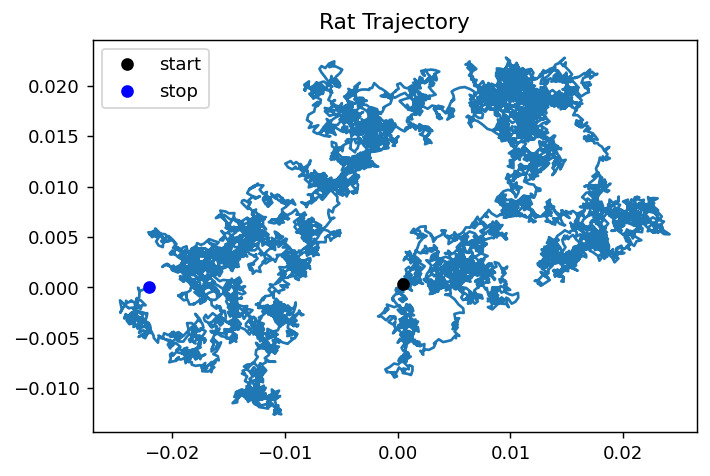

In [13]:
#@title Simulated Velocity Inputs:

def simulate_random_velocity(duration, dt, step_size):
    """
    Inputs
    
    """
    x = step_size * cumsum((random(int(duration/dt)) - 0.5))
    y = step_size * cumsum((random(int(duration/dt)) - 0.5))

    # velocity = column_stack((x, y))

    return x / second, y / second

step_size = 0.001*metre
dt = 0.1*ms
velocity_array_x, velocity_array_y = simulate_random_velocity(duration, dt, step_size)


figure(dpi=130)
plot(velocity_array_x[:], velocity_array_y[:])
plot(velocity_array_x[0], velocity_array_y[0], 'ro', color='black', label='start')
plot(velocity_array_x[-1], velocity_array_y[-1], 'ro', color='blue', label='stop')
title("Rat Trajectory")
legend()



In [14]:
V_x = TimedArray(velocity_array_x, dt=dt)
V_y = TimedArray(velocity_array_y, dt=dt)

In [15]:
print(V_x(1*second))

-0.02201273 m/s


In [16]:
print("Running the simulation")
run(duration)

Running the simulation


WARNING    "xi" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup_4", but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "xi" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 3. The internal variable will be

-0.00035178445528074453
0.0004958577904744059
-0.0004958577904744059
0.00035178445528074453
0.0001463338842562909
0.0009861108543224853
-0.0009861108543224853
-0.0001463338842562909
0.00016882011574835665
0.001108942480734212
-0.001108942480734212
-0.00016882011574835665
0.0003252461216180055
0.0012787177258836492
-0.0012787177258836492
-0.0003252461216180055
0.00012139702397007957
0.001047499513109407
-0.001047499513109407
-0.00012139702397007957
-0.00014696285546690656
0.0006317026125414363
-0.0006317026125414363
0.00014696285546690656
-0.00024097349378648426
0.00022731708711750043
-0.00022731708711750043
0.00024097349378648426
-0.0004219601118508234
0.0004820651747172621
-0.0004820651747172621
0.0004219601118508234
-0.00017716596306227862
0.0007739955829502973
-0.0007739955829502973
0.00017716596306227862
-2.2351864301662917e-05
0.0011451166983346532
-0.0011451166983346532
2.2351864301662917e-05
-0.00013066236082919059
0.0011543098053967895
-0.0011543098053967895
0.00013066236082919

In [19]:
M_i.num_spikes

NameError: name 'M_i' is not defined

## Plot Connectivity

S:
* 0 - 4 : north > north, south, east, west, inh
* 5 - 9 : south > north, south, east, west, inh
* 10 - 14: east > north, south, east, west, inh


(10000,)
(100,)
[[0.         0.         0.         0.89779646 0.69885992 0.57474798
  0.57474798 0.69885992 0.89779646 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         

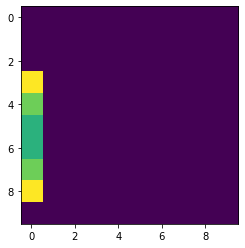

In [23]:
i = 8 # source neuron
print(S[1].w.shape)
connectivity = S[1].w[i*N : (i+1)*N]
print(connectivity.shape)
connectivity = connectivity.reshape(int(sqrt(N)), int(sqrt(N)))
imshow(connectivity.T)
print(connectivity)

(100,)
[[0.04       0.30699726 0.79597122 0.06244386 0.09340459 0.96084028
  0.18566122 0.04331253 0.4865726  0.57522088]
 [1.         1.         0.06104235 0.11843403 1.         0.12347282
  0.052798   0.69220178 0.37924362 0.04055264]
 [0.04       0.30699726 0.04       0.81492369 0.17374889 0.04992704
  0.71094736 0.33256298 0.04       0.32610447]
 [1.         0.06104235 0.06104235 1.         0.04504903 0.35298784
  0.53248884 0.04124648 0.27858795 0.77129446]
 [0.04       0.81492369 0.79597122 0.81492369 0.04       0.92566137
  0.08609679 0.11281695 0.97569748 0.07628895]
 [1.         0.04504903 0.11843403 0.11843403 0.04504903 1.
  0.04222343 0.557679   0.24966026 0.04779537]
 [0.04       0.92566137 0.17374889 0.06244386 0.17374889 0.92566137
  0.04       0.96084028 0.06323184 0.21376418]
 [1.         0.04222343 0.35298784 1.         1.         0.35298784
  0.04222343 1.         0.04124648 0.69220178]
 [0.04       0.96084028 0.08609679 0.04992704 0.09340459 0.04992704
  0.08609679 

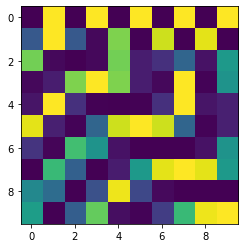

In [22]:
num = 100
test_connectivity = exc_to_any_connectivity(int(sqrt(num)), 0, 0)

print(test_connectivity.shape)
test_connectivity = test_connectivity.reshape(int(sqrt(num)), int(sqrt(num)))
imshow(test_connectivity.T)
print(test_connectivity)

(100,)
[[0.04       0.04962542 0.08944272 0.2        0.4472136  0.80603848
  0.         0.         0.         0.        ]
 [0.04962542 0.0609662  0.10686665 0.22927089 0.48840519 0.83879115
  0.         0.         0.         0.        ]
 [0.08944272 0.10686665 0.17311002 0.33033524 0.61378071 0.92064493
  0.         0.         0.         0.        ]
 [0.2        0.22927089 0.33033524 0.53014667 0.80603848 0.99371926
  0.         0.         0.         0.        ]
 [0.4472136  0.48840519 0.61378071 0.80603848 0.97442495 0.
  0.         0.         0.         0.        ]
 [0.80603848 0.83879115 0.92064493 0.99371926 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        

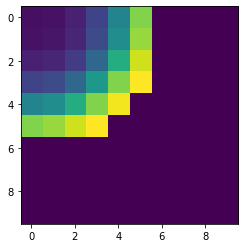

In [23]:
test_connectivity_1 = zeros(100)

for j in range(100):
    y_j = j // 10
    x_j = j % 10
    distance = linalg.norm(array([x_j, y_j]))
    if distance < r_w_plus:
        test_connectivity_1[j] = w_mag_plus**(1 + cos(pi*distance/r_w_plus))

print(test_connectivity_1.shape)
test_connectivity_1 = test_connectivity_1.reshape(10, 10)
imshow(test_connectivity_1.T)
print(test_connectivity_1)

(100,)
[[0.2        0.08944272 0.04962542 0.04       0.04962542 0.08944272
  0.2        0.4472136  0.80603848 0.        ]
 [0.22927089 0.10686665 0.0609662  0.04962542 0.0609662  0.10686665
  0.22927089 0.48840519 0.83879115 0.        ]
 [0.33033524 0.17311002 0.10686665 0.08944272 0.10686665 0.17311002
  0.33033524 0.61378071 0.92064493 0.        ]
 [0.53014667 0.33033524 0.22927089 0.2        0.22927089 0.33033524
  0.53014667 0.80603848 0.99371926 0.        ]
 [0.80603848 0.61378071 0.48840519 0.4472136  0.48840519 0.61378071
  0.80603848 0.97442495 0.         0.        ]
 [0.99371926 0.92064493 0.83879115 0.80603848 0.83879115 0.92064493
  0.99371926 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.   

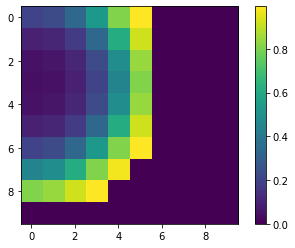

In [24]:
test_connectivity_2 = zeros(100)

x_dir = 1
y_dir = 0
for j in range(100):
    y_j = j // 10
    x_j = j % 10
    distance = linalg.norm(array([x_j - x_dir*xi, y_j - y_dir*xi]))
    if distance < r_w_plus:
        test_connectivity_2[j] = w_mag_plus**(1 + cos(pi*distance/r_w_plus))

print(test_connectivity_2.shape)
test_connectivity_2 = test_connectivity_2.reshape(10, 10)
imshow(test_connectivity_2.T)
print(test_connectivity_2)
colorbar()

(10000,)
(100,)
[[0.         0.         0.         0.99685468 0.98712965 0.99685468
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         

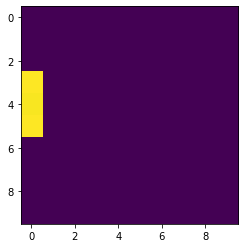

In [27]:
test_connectivity_whole = exc_to_any_connectivity(N, x_dir, y_dir)

i = 5 # source neuron
print(test_connectivity_whole.shape)
test_connectivity_3 = test_connectivity_whole[i*N : (i+1)*N]

print(test_connectivity_3.shape)
test_connectivity_3 = test_connectivity_3.reshape(10, 10)
imshow(test_connectivity_3.T)
print(test_connectivity_3)

(9900,)
(10000,)
[0.4472136  0.32690465 0.32690465 ... 0.         0.         0.        ]


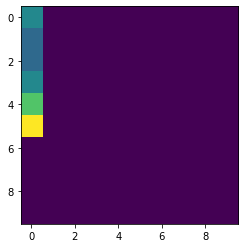

In [34]:
i = 0 # source neuron
print(S[0].w.shape)
connectivity = S[1].w[:]
print(connectivity.shape)
connectivity_i = connectivity.reshape(N, N)[i, :]
connectivity_matrix = connectivity_i.reshape(10, 10)
imshow(connectivity_matrix.T)
print(connectivity)

(10000,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


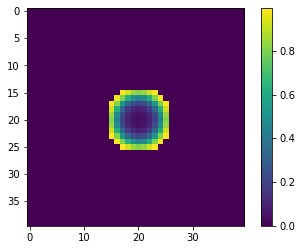

In [22]:
test_connectivity_2 = zeros(10000)

x_dir = 0
y_dir = 0

i = 5050
y_i = i // 100
x_i = i % 100

for j in range(10000):
    y_j = j // 100
    x_j = j % 100
    distance = linalg.norm(array([x_j - x_i - x_dir*xi, y_j - y_i - y_dir*xi]))
    if distance < r_w_plus:
        test_connectivity_2[j] = w_mag_plus**(1 + cos(pi*distance/r_w_plus))

print(test_connectivity_2.shape)
test_connectivity_2 = test_connectivity_2.reshape(100, 100)
imshow(test_connectivity_2.T[30:70, 30:70])
print(test_connectivity_2)
colorbar()

(100, 100)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


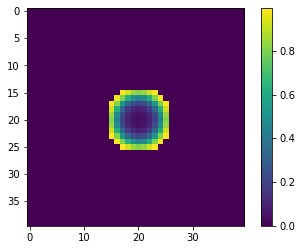

In [24]:

test_connectivity_5 = zeros(10000)

x_dir = 0
y_dir = 0

i = 5050
y_i = i // 100
x_i = i % 100

for j in range(10000):
    y_j = j // 100
    x_j = j % 100
    distance = linalg.norm(array([x_j - x_i - x_dir*xi, y_j - y_i - y_dir*xi]))
    if distance < r_w_plus:
        test_connectivity_5[j] = w_mag_minus**((1 + cos(pi*distance/r_w_minus))/2)

print(test_connectivity_2.shape)
test_connectivity_2 = test_connectivity_2.reshape(100, 100)
imshow(test_connectivity_2.T[30:70, 30:70])
print(test_connectivity_2)
colorbar()